In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python

ERROR: Operation cancelled by user


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
import pickle
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from  torch.optim.lr_scheduler import StepLR

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid

from random import randint

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

import cv2

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
train_df = pd.read_pickle("/content/drive/My Drive/551A3/images_l.pkl")
label_df = pd.read_pickle("/content/drive/My Drive/551A3/labels_l.pkl")
test_df = pd.read_pickle("/content/drive/My Drive/551A3/images_test.pkl")

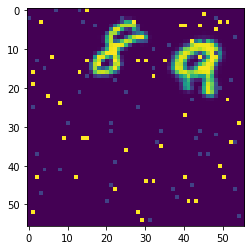

In [ ]:
image = test_df[2000]
pixels = image.reshape((56, 56))
plt.imshow(pixels)

In [ ]:
cut = int(30000 * 0.9)

image_train_base = train_df[:cut]
label_train_base = label_df[:cut]

image_val_base = train_df[cut:]
label_val_base = label_df[cut:]

In [ ]:
# double the dataset
image_train = np.append(image_train_base, image_train_base, axis=0)
label_train = np.append(label_train_base, label_train_base, axis=0)

image_val = np.append(image_val_base, image_val_base, axis=0)
label_val = np.append(label_val_base, label_val_base, axis=0)

In [ ]:
# double again
image_train = np.append(image_train, image_train, axis=0)
label_train = np.append(label_train, label_train, axis=0)

image_val = np.append(image_val, image_val, axis=0)
label_val = np.append(label_val, label_val, axis=0)

In [ ]:
def denoise(src):
  blur_data = cv2.GaussianBlur(src, (3, 1), 0)
  retval, denoised_data = cv2.threshold(blur_data, 85, maxval=255, type=cv2.THRESH_TOZERO)

  return denoised_data

In [ ]:
image_train = denoise(image_train)
image_val = denoise(image_val)
test_df = denoise(test_df)

In [ ]:
class Transform_Dataset(Dataset):
  def __init__(self, X, 
               transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(224),
                  transforms.ToTensor(), transforms.Normalize(mean=(0.0,), std=(1.0,))])):
  
    self.X = X.astype(np.uint8)[:,:,:,None]
    # self.X = X
    self.transform = transform
    
  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.transform(self.X[idx]).to(device)

In [ ]:
RandAffine = transforms.RandomAffine(degrees=30, translate=(0, 0), scale=(1.0, 1.0))

train_transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize(224),
  RandAffine.to(device),
  transforms.ToTensor(),
  transforms.Normalize(mean=(0.0,), std=(1.0,)).to(device)
])

In [ ]:
batch_s = 30

train_dataset = Transform_Dataset(image_train, train_transform)
images_l_loader = DataLoader(dataset=train_dataset, batch_size=batch_s, shuffle=False)

val_dataset = Transform_Dataset(image_val, train_transform)
images_val_loader = DataLoader(dataset=val_dataset, batch_size=batch_s, shuffle=False)

labels_l_loader = DataLoader(dataset=label_train, batch_size=batch_s, shuffle=False)

test_dataset = Transform_Dataset(test_df)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False)

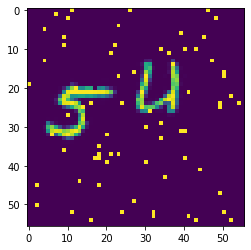

In [ ]:
image = train_df[162]
pixels = image.reshape((56, 56))
plt.imshow(pixels)

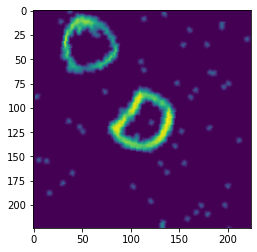

In [ ]:
image = train_dataset[252].cpu().detach().numpy()
pixels = image.reshape((224, 224))
plt.imshow(pixels)

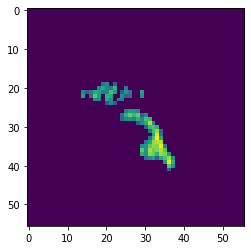

In [ ]:
image = test_df[162]
pixels = image.reshape((56, 56))
plt.imshow(pixels)

In [ ]:
# Loss function
criterion = nn.CrossEntropyLoss().to(device)

In [ ]:
def train(model, dropout, epochs, images_training, labels_training, images_val = images_val_loader, labels_valid = label_val, lr = 0.01):
  input_dim = 56*56
  output_dim = 36
  model_g = model(input_dim,output_dim,dropout).to(device)
  # optimizer = optim.SGD(model_g.parameters(), lr=0.001, momentum=0.9)
  
  total_loss = []
  total_acc = []
  total_training_acc = []
  for epoch in range(epochs):
    dataloader_iterator = iter(images_training)
    #val_iterator = iter(images_val_loader)
    running_loss = 0.0
    for i, labels in enumerate(labels_training,0):
      inputs = next(dataloader_iterator).to(device)
      optimizer.zero_grad()
      inputs = inputs.float().to(device)
      outputs = model_g(inputs).to(device)
      #print(outputs)
      loss = criterion(outputs, labels.to(device)).to(device)
      loss.backward()
      optimizer.step()
    total_loss.append(loss.item())
    val_accuracy = accuracy(images_val, labels_valid, model_g)
    # train_acc = accuracy(images_training, label_train, model_g)
    # total_training_acc.append(train_acc)
    total_acc.append(val_accuracy)
    # print('[%d] loss: %.3f training_accuracy: %.4f val_accuracy: %.4f' % (epoch + 1, loss.item(), train_acc, val_accuracy))
    print('[%d] loss: %.3f  val_accuracy: %.4f' % (epoch + 1, loss.item(), val_accuracy))
  return model_g, total_loss, total_training_acc, total_acc

In [ ]:
def predict(model, data_loader):
  total_output = []
  for i, data in enumerate(data_loader):
    if torch.cuda.is_available():
      output = model(data).cpu().detach().numpy()
    else:
      output = model(data).detach().numpy()
    # print(output.shape)

    for row_output in output:
      # print(row_output.shape)
      # find the max two number
      max1 = np.max(row_output[:10])
      # print(output_without_max1.shape)
      max2 = np.max(row_output[10:])
      # print("max1 = ", max1)
      # print("max2 = ", max2)
      # find index of max1 and max2
      max1_index = np.where(row_output == max1)
      max2_index = np.where(row_output == max2)
      # print(max1_index)
      # print(max2_index)
      row_output = np.zeros(row_output.shape, dtype=int)

      row_output[max1_index[0][0]] = 1
      row_output[max2_index[0][0]] = 1

      # print(np.where(row_output == 1))
      total_output.append(row_output)
    
  return np.array(total_output)


In [ ]:
def accuracy(images_val_loader, labels_val, model):
  correct = 0
  total = 0
  output = predict(model,images_val_loader)
  i = 0
  labels = labels_val.astype(int)
  while i < len(output):
    #print(output[i])
    #print(labels[i])
    if (output[i] == labels[i]).all():
      correct += 1
    total += 1
    i += 1
  return correct/total

In [ ]:
# 4 layer with dropout
class Net_4layers(nn.Module):
    def __init__(self, input_dim, output_dim, dropout):
        super(Net_4layers, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, 2).to(device),
            nn.ReLU().to(device),
            # nn.MaxPool2d(2),
            nn.Conv2d(32, 32, 2).to(device),
            nn.BatchNorm2d(32).to(device),
            nn.ReLU().to(device),
            nn.MaxPool2d(2).to(device),
            # nn.Dropout(dropout).to(device),
            nn.ReLU().to(device)
        ).to(device)

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, 2).to(device),
            nn.ReLU().to(device),
            nn.Conv2d(64, 64, 3).to(device),
            nn.BatchNorm2d(64).to(device),
            nn.ReLU().to(device),
            nn.MaxPool2d(2).to(device),
            # nn.Dropout(dropout).to(device),
            nn.ReLU().to(device)
        ).to(device)

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3).to(device),
            nn.ReLU().to(device),
            nn.Conv2d(128, 128, 3).to(device),
            # nn.BatchNorm2d(128).to(device),
            nn.ReLU().to(device),
            nn.MaxPool2d(2).to(device),
            nn.Dropout(dropout).to(device),
            # nn.ReLU().to(device)
        ).to(device)
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, 2).to(device),
            nn.ReLU().to(device),
            nn.Conv2d(256, 256, 2).to(device),
            nn.BatchNorm2d(256).to(device),
            nn.ReLU().to(device),
            nn.MaxPool2d(2).to(device),
            # nn.Dropout(dropout).to(device),
            # nn.ReLU().to(device)
        ).to(device)
        
        self.fc = nn.Linear(256, output_dim).to(device)
        #self.fc = nn.Softmax()
    def forward(self, x):
      x = self.layer1(x)
      # print("layer 1")
      x = self.layer2(x)
      # print("layer 2")
      x = self.layer3(x)
      # print("layer 3")
      x = self.layer4(x)
      # print("layer 4")
      x = x.reshape(x.size(0), -1)
      x = self.fc(x)
      return x

In [ ]:
model_4l, loss_4l, train_acc_4l, acc_4l = train(Net_4layers, 0.001, 20, images_l_loader, labels_l_loader)

[1] loss: 4.504  val_accuracy: 0.3002
[2] loss: 3.484  val_accuracy: 0.4773
[3] loss: 3.201  val_accuracy: 0.6093
[4] loss: 2.804  val_accuracy: 0.6739
[5] loss: 2.819  val_accuracy: 0.7088
[6] loss: 2.430  val_accuracy: 0.7296
[7] loss: 2.362  val_accuracy: 0.7442
[8] loss: 2.374  val_accuracy: 0.7590
[9] loss: 2.313  val_accuracy: 0.7664
[10] loss: 2.569  val_accuracy: 0.7715
[11] loss: 2.387  val_accuracy: 0.7769
[12] loss: 2.219  val_accuracy: 0.7807
[13] loss: 2.142  val_accuracy: 0.7918
[14] loss: 2.130  val_accuracy: 0.7889
[15] loss: 2.408  val_accuracy: 0.7935
[16] loss: 2.107  val_accuracy: 0.7914
[17] loss: 2.068  val_accuracy: 0.7979
[18] loss: 2.161  val_accuracy: 0.8035
[19] loss: 2.105  val_accuracy: 0.8042
[20] loss: 2.042  val_accuracy: 0.8063


In [ ]:
model_4l, loss_4l, train_acc_4l, acc_4l = train(Net_4layers, 0.001, 20, images_l_loader, labels_l_loader)

In [ ]:
test_predictions = predict(model_4l, test_loader)
# print(test_predictions.shape)

d = {'Id' : [x for x in range(0, len(test_predictions))], 'Category' : [''.join([str(i) for i in x]) for x in test_predictions.tolist()]}
submission = pd.DataFrame(d)
submission.rename(columns={'Id':'# Id'}, inplace=True)
print(submission.shape)
submission.to_csv(path_or_buf='submission.csv', index=False)

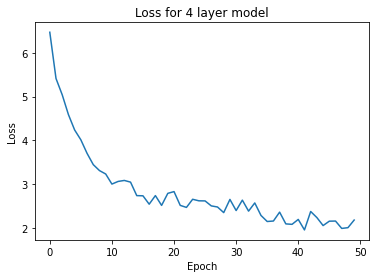

In [ ]:
plt.title("Loss for 4 layer model")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_4l)
plt.show()

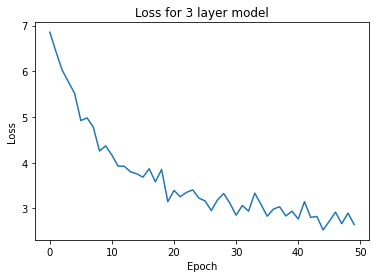

In [ ]:
plt.title("Loss for 3 layer model")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_3l)
plt.show()

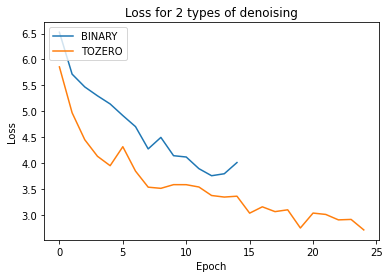

In [ ]:
plt.title("Loss for 2 types of denoising")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_bi)
plt.plot(loss_tz)
plt.legend(["BINARY","TOZERO"], loc='upper left')
plt.show()

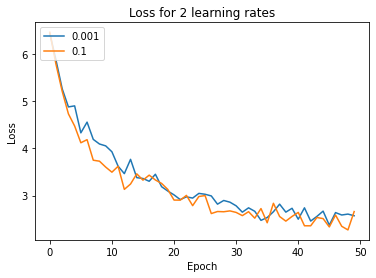

In [ ]:
plt.title("Loss for 2 learning rates")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_tz)
plt.plot(loss_tz1)
plt.legend(["0.001","0.1"], loc='upper left')
plt.show()

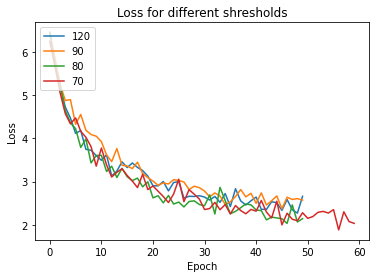

In [ ]:
plt.title("Loss for different shresholds")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_tz1)
plt.plot(loss_tz)
plt.plot(loss_tz80)
plt.plot(loss_tz70)
plt.legend(["120","90","80","70"], loc='upper left')
plt.show()

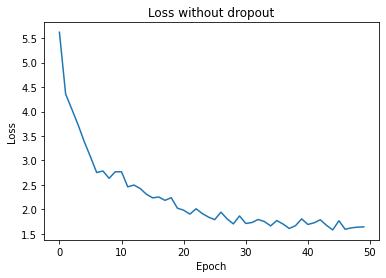

In [ ]:
plt.title("Loss without dropout")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(loss_tz80)
plt.show()

## VGG

In [ ]:
vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
                512, 512, 512, 512, 'M']

In [ ]:
def get_vgg_layers(config, batch_norm):
    
    layers = []
    in_channels = 1
    
    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2).to(device)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1).to(device)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c).to(device), nn.ReLU(inplace = True).to(device)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True).to(device)]
            in_channels = c
            
    return nn.Sequential(*layers).to(device)

In [ ]:
class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        
        self.features = features
        
        self.avgpool = nn.AdaptiveAvgPool2d(7).to(device)
        
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096).to(device),
            nn.ReLU(inplace = True).to(device),
            nn.Dropout(0.5).to(device),
            nn.Linear(4096, 4096).to(device),
            nn.ReLU(inplace = True).to(device),
            nn.Dropout(0.5).to(device),
            nn.Linear(4096, output_dim).to(device),
        ).to(device)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x
      

In [ ]:
vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = False)
vgg11_layers_bn = get_vgg_layers(vgg11_config, batch_norm = True)

vgg13_layers = get_vgg_layers(vgg13_config, batch_norm = False)
vgg13_layers_bn = get_vgg_layers(vgg13_config, batch_norm = True)

vgg16_layers = get_vgg_layers(vgg16_config, batch_norm = False)
vgg16_layers_bn = get_vgg_layers(vgg16_config, batch_norm = True)

vgg19_layers = get_vgg_layers(vgg19_config, batch_norm = False)
vgg19_layers_bn = get_vgg_layers(vgg19_config, batch_norm = True)

In [ ]:
def train_vgg(model, epoches, image_train_loader, label_train_loader, image_val_loader, label_val):

  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  for epoch in range(epoches):
    image_train_dl_iterator = iter(image_train_loader)

    for i, label in enumerate(label_train_loader, 0):
      inputs = next(image_train_dl_iterator).to(device)
      inputs = inputs.float().to(device)

      optimizer.zero_grad()

      outputs = model(inputs).to(device)

      loss = criterion(outputs, label.to(device)).to(device)
      loss.backward()

      optimizer.step()

    val_accuracy = accuracy(image_val_loader, label_val, model)
    print('[%d] loss: %.3f  val_accuracy: %.4f' % (epoch + 1, loss.item(), val_accuracy))

  return model

In [ ]:
OUTPUT_DIM = 36

VGG11 = VGG(vgg11_layers, OUTPUT_DIM)
VGG11_bn = VGG(vgg11_layers_bn, OUTPUT_DIM)

VGG13 = VGG(vgg13_layers, OUTPUT_DIM)
VGG13_bn = VGG(vgg13_layers_bn, OUTPUT_DIM)

VGG16 = VGG(vgg16_layers, OUTPUT_DIM)
VGG16_bn = VGG(vgg16_layers_bn, OUTPUT_DIM)

VGG19 = VGG(vgg19_layers, OUTPUT_DIM)
VGG19_bn = VGG(vgg19_layers_bn, OUTPUT_DIM)

In [ ]:
model_vgg11 = train_vgg(VGG11, 15, images_l_loader, labels_l_loader, images_val_loader, label_val)

NameError: ignored

In [ ]:
model_vgg11_bn = train_vgg(VGG11_bn, 15, images_l_loader, labels_l_loader, images_val_loader, label_val)

In [ ]:
model_vgg13 = train_vgg(VGG13, 10, images_l_loader, labels_l_loader, images_val_loader, label_val)

In [ ]:
model_vgg13_bn = train_vgg(VGG13_bn, 10, images_l_loader, labels_l_loader, images_val_loader, label_val)

[1] loss: 2.327  val_accuracy: 0.8154
[2] loss: 2.133  val_accuracy: 0.8387
[3] loss: 1.733  val_accuracy: 0.8514
[4] loss: 1.715  val_accuracy: 0.8503


KeyboardInterrupt: ignored

In [ ]:
test_predictions = predict(VGG13_bn, test_loader)
# print(test_predictions.shape)

d = {'Id' : [x for x in range(0, len(test_predictions))], 'Category' : [''.join([str(i) for i in x]) for x in test_predictions.tolist()]}
submission = pd.DataFrame(d)
submission.rename(columns={'Id':'# Id'}, inplace=True)
print(submission.shape)
submission.to_csv(path_or_buf='submission_vgg13bn.csv', index=False)

(15000, 2)


In [ ]:
model_vgg16 = train_vgg(VGG16, 10, images_l_loader, labels_l_loader, images_val_loader, label_val)

In [ ]:
model_vgg16_bn = train_vgg(VGG16_bn, 20, images_l_loader, labels_l_loader, images_val_loader, label_val)

[1] loss: 2.843  val_accuracy: 0.6468


In [ ]:
test_predictions = predict(VGG16_bn, test_loader)
# print(test_predictions.shape)

d = {'Id' : [x for x in range(0, len(test_predictions))], 'Category' : [''.join([str(i) for i in x]) for x in test_predictions.tolist()]}
submission = pd.DataFrame(d)
submission.rename(columns={'Id':'# Id'}, inplace=True)
print(submission.shape)
submission.to_csv(path_or_buf='submission_vgg16bn.csv', index=False)

In [ ]:
model_vgg19 = train_vgg(VGG19, 10, images_l_loader, labels_l_loader, images_val_loader, label_val)

In [ ]:
model_vgg19_bn = train_vgg(VGG19_bn, 10, images_l_loader, labels_l_loader, images_val_loader, label_val)

## ResNet

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()
                
        block, n_blocks, channels = config
        self.in_channels = channels[0]
            
        assert len(n_blocks) == len(channels) == 4
        
        self.conv1 = nn.Conv2d(1, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False).to(device)
        self.bn1 = nn.BatchNorm2d(self.in_channels).to(device)
        self.relu = nn.ReLU(inplace = True).to(device)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1).to(device)
        
        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0]).to(device)
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2).to(device)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2).to(device)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2).to(device)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1)).to(device)
        self.fc = nn.Linear(self.in_channels, output_dim).to(device)
        
    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):
    
        layers = []
        
        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False
        
        layers.append(block(self.in_channels, channels, stride, downsample))
        
        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels
            
        return nn.Sequential(*layers).to(device)
        
    def forward(self, x):
        
        x = self.conv1(x).to(device)
        x = self.bn1(x).to(device)
        x = self.relu(x).to(device)
        x = self.maxpool(x).to(device)

        x = self.layer1(x).to(device)
        x = self.layer2(x).to(device)
        x = self.layer3(x).to(device)
        x = self.layer4(x).to(device)
        
        x = self.avgpool(x).to(device)
        h = x.view(x.shape[0], -1)
        x = self.fc(h).to(device)
        
        return x

In [ ]:
class BasicBlock(nn.Module):
    
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
                
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False).to(device)
        self.bn1 = nn.BatchNorm2d(out_channels).to(device)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = 1, padding = 1, bias = False).to(device)
        self.bn2 = nn.BatchNorm2d(out_channels).to(device)
        
        self.relu = nn.ReLU(inplace = True).to(device)
        
        if downsample:
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                             stride = stride, bias = False).to(device)
            bn = nn.BatchNorm2d(out_channels).to(device)
            downsample = nn.Sequential(conv, bn).to(device)
        else:
            downsample = None
        
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x).to(device)
        x = self.bn1(x).to(device)
        x = self.relu(x).to(device)
        
        x = self.conv2(x).to(device)
        x = self.bn2(x).to(device)
        
        if self.downsample is not None:
            i = self.downsample(i)
                        
        x += i
        x = self.relu(x).to(device)
        
        return x

In [ ]:
class Bottleneck(nn.Module):
    
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()
    
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1, 
                               stride = 1, bias = False).to(device)
        self.bn1 = nn.BatchNorm2d(out_channels).to(device)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                               stride = stride, padding = 1, bias = False).to(device)
        self.bn2 = nn.BatchNorm2d(out_channels).to(device)
        
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False).to(device)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels).to(device)
        
        self.relu = nn.ReLU(inplace = True).to(device)
        
        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1, 
                             stride = stride, bias = False).to(device)
            bn = nn.BatchNorm2d(self.expansion * out_channels).to(device)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None
            
        self.downsample = downsample
        
    def forward(self, x):
        
        i = x
        
        x = self.conv1(x).to(device)
        x = self.bn1(x).to(device)
        x = self.relu(x).to(device)
        
        x = self.conv2(x).to(device)
        x = self.bn2(x).to(device)
        x = self.relu(x).to(device)
        
        x = self.conv3(x).to(device)
        x = self.bn3(x).to(device)
                
        if self.downsample is not None:
            i = self.downsample(i)
            
        x += i
        x = self.relu(x).to(device)
    
        return x

In [ ]:
from collections import namedtuple

ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])

resnet18_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [2,2,2,2],
                               channels = [64, 128, 256, 512])

resnet34_config = ResNetConfig(block = BasicBlock,
                               n_blocks = [3,4,6,3],
                               channels = [64, 128, 256, 512])

resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])

resnet101_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 4, 23, 3],
                                channels = [64, 128, 256, 512])

resnet152_config = ResNetConfig(block = Bottleneck,
                                n_blocks = [3, 8, 36, 3],
                                channels = [64, 128, 256, 512])

In [ ]:
OUTPUT_DIM = 36

Resnet18 = ResNet(resnet18_config, OUTPUT_DIM)
Resnet34 = ResNet(resnet34_config, OUTPUT_DIM)
Resnet50 = ResNet(resnet50_config, OUTPUT_DIM)
Resnet101 = ResNet(resnet101_config, OUTPUT_DIM)
Resnet152 = ResNet(resnet152_config, OUTPUT_DIM)

In [ ]:
def train_resnet(model, epoches, image_train_loader, label_train_loader, image_val_loader, label_val):

  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  for epoch in range(epoches):
    image_train_dl_iterator = iter(image_train_loader)

    for i, label in enumerate(label_train_loader, 0):
      inputs = next(image_train_dl_iterator).to(device)
      inputs = inputs.float().to(device)

      optimizer.zero_grad()

      outputs = model(inputs).to(device)

      loss = criterion(outputs, label.to(device)).to(device)
      loss.backward()

      optimizer.step()

    val_accuracy = accuracy(image_val_loader, label_val, model)
    print('[%d] loss: %.3f  val_accuracy: %.4f' % (epoch + 1, loss.item(), val_accuracy))

  return model

In [ ]:
train_resnet(Resnet18, 25, images_l_loader, labels_l_loader, images_val_loader, label_val)

[1] loss: 7.290  val_accuracy: 0.0039


KeyboardInterrupt: ignored

In [ ]:
test_predictions = predict(Resnet18, test_loader)
# print(test_predictions.shape)

d = {'# Id' : [x for x in range(0, len(test_predictions))], 'Category' : [''.join([str(i) for i in x]) for x in test_predictions.tolist()]}
submission = pd.DataFrame(d)
print(submission.shape)
submission.to_csv(path_or_buf='submission_resnet18.csv', index=False)

(15000, 2)


In [ ]:
train_resnet(Resnet34, 25, images_l_loader, labels_l_loader, images_val_loader, label_val)

In [ ]:
train_resnet(Resnet50, 25, images_l_loader, labels_l_loader, images_val_loader, label_val)

In [ ]:
train_resnet(Resnet101, 25, images_l_loader, labels_l_loader, images_val_loader, label_val)

In [ ]:
train_resnet(Resnet152, 25, images_l_loader, labels_l_loader, images_val_loader, label_val)

## AlexNet

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2).to(device),
            nn.ReLU(inplace=True).to(device),
            nn.MaxPool2d(kernel_size=3, stride=2).to(device),
            nn.Conv2d(64, 192, kernel_size=5, padding=2).to(device),
            nn.ReLU(inplace=True).to(device),
            nn.MaxPool2d(kernel_size=3, stride=2).to(device),
            nn.Conv2d(192, 384, kernel_size=3, padding=1).to(device),
            nn.ReLU(inplace=True).to(device),
            nn.Conv2d(384, 256, kernel_size=3, padding=1).to(device),
            nn.ReLU(inplace=True).to(device),
            nn.Conv2d(256, 256, kernel_size=3, padding=1).to(device),
            nn.ReLU(inplace=True).to(device),
            nn.MaxPool2d(kernel_size=3, stride=2).to(device),
        ).to(device)

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6)).to(device)

        self.classifier = nn.Sequential(
            nn.Dropout(0.5).to(device),
            nn.Linear(256 * 6 * 6, 4096).to(device),
            nn.ReLU(inplace=True).to(device),
            nn.Dropout(0.5).to(device),
            nn.Linear(4096, 4096).to(device),
            nn.ReLU(inplace=True).to(device),
            nn.Linear(4096, output_dim).to(device),
        ).to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1).to(device)
        x = self.classifier(x)
        return x

In [ ]:
alexNet = AlexNet(OUTPUT_DIM)

In [ ]:
def train_alexnet(model, epoches, image_train_loader, label_train_loader, image_val_loader, label_val):

  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

  for epoch in range(epoches):
    image_train_dl_iterator = iter(image_train_loader)

    for i, label in enumerate(label_train_loader, 0):
      inputs = next(image_train_dl_iterator).to(device)
      inputs = inputs.float().to(device)

      optimizer.zero_grad()

      outputs = model(inputs).to(device)

      loss = criterion(outputs, label.to(device)).to(device)
      loss.backward()

      optimizer.step()

    val_accuracy = accuracy(image_val_loader, label_val, model)
    print('[%d] loss: %.3f  val_accuracy: %.4f' % (epoch + 1, loss.item(), val_accuracy))

  return model

In [ ]:
train_alexnet(alexNet, 15, images_l_loader, labels_l_loader, images_val_loader, label_val)

[1] loss: 6.963  val_accuracy: 0.0050
[2] loss: 6.647  val_accuracy: 0.0107


KeyboardInterrupt: ignored